In [2]:
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import colormaps

### 1. (10 баллов) 
##### *Реализуйте нелинейный генератор псевдослучайных чисел с квадратичной зависимость между состояниями генератора. Опишите пространство состояний и период вашего генератора. Проведите для него тесты случайности NIST*

### 2. (10 баллов) Рассмотрим функцию распределения вида:
$$ \xi \propto \mathrm{N}(-1, \  \sigma_{-1}^2) + С_0(0, \gamma_0)  + \mathrm{N}(1, \  \sigma_{+1}^2) = \mathrm{N}(0, \  \sigma_{-1}^2 +  \sigma_{+1}^2) + С_0(0, \gamma_0)$$

Где $\mathrm{N}$ - нормальное распределение, $C_0$ - распределение Коши

##### 1. Как известно из курса теории вероятностей, плотность вероятности суммых двух случ.величин может быть найдена по формуле свертки:

$$p_{\xi} (x) = \int_{-\infty}^{\infty} p_N(y) \cdot p_C(x - y) dy = \int_{-\infty}^{\infty} \frac{1}{\sqrt{2\pi (\sigma_{-1}^2 + \sigma_{+1}^2)}} \exp (\frac{-y^2}{2(\sigma_{-1}^2 + \sigma_{+1}^2)}) \cdot \frac{1}{\pi \cdot \gamma_0} \cdot \frac{1}{1 + (x - y)^2/\gamma_0^2} dy$$

И не может быть выражена аналитически....для так называемого `Voigt profile`. Зато он реализован в `scipy.special`, чем я неприменю воспользоваться

In [3]:
from scipy.special import voigt_profile

In [4]:
pde_voigt = lambda x, sigma, gamma: voigt_profile(x, sigma, gamma)

Text(0, 0.5, '$P_\\xi(x)$')

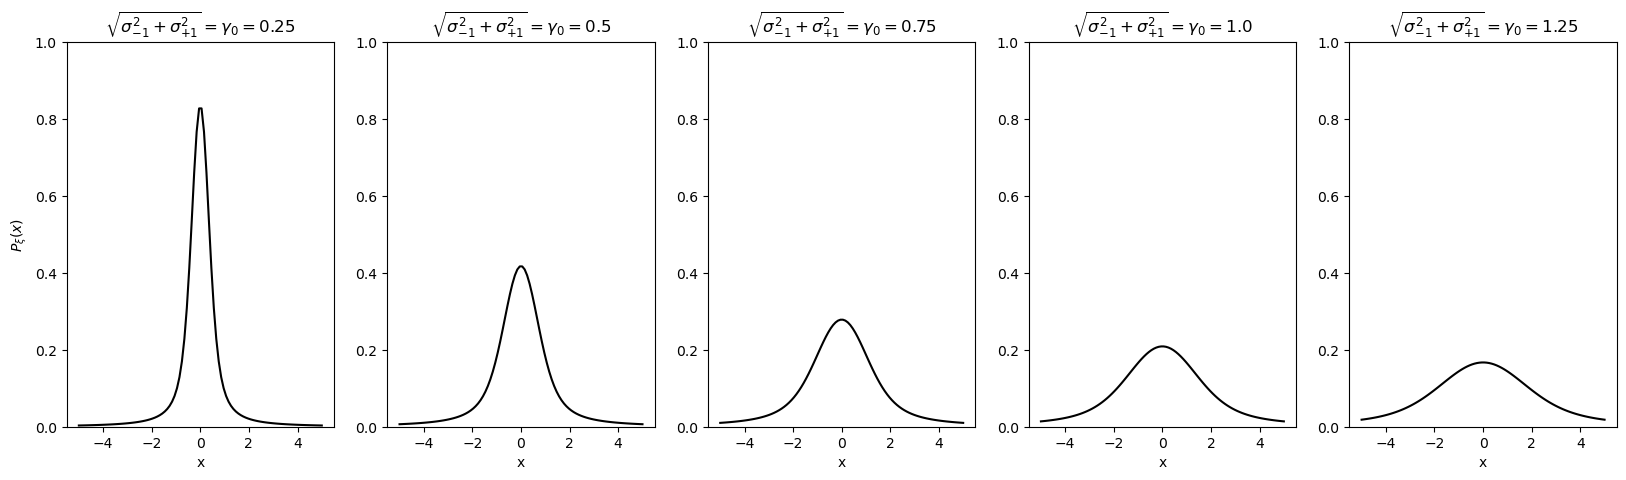

In [16]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

set_of_specs = np.arange(0.25, 1.5, 0.25)

for i, spec in enumerate(set_of_specs):
    ax[i].set_title(r'$\sqrt{\sigma_{-1}^2  +  \sigma_{+1}^2} = \gamma_0 = $' + f'{spec}')
    ax[i].plot(np.linspace(-5, 5, 100), pde_voigt(np.linspace(-5, 5, 100), spec, spec), color='blacK')
    ax[i].set_xlabel('x')
    ax[i].set_ylim(0, 1)

ax[0].set_ylabel(r'$P_\xi(x)$')

##### 2.1 Первый метод который реализуем - неэффективный метод браковки, т.к он будет показательно различаться для разных значений параметра

In [6]:
def rejection_sampling(pde, params, call=0):
    """
    Input: (pde, params, call=0):
    pde    - probability density function, function
    params - parameters to be inserted in pde
    call   - rejection sampling iteration 

    Output -> (call, x1, x2):
    call   - final number of rejection-sampling iterations
    x1     - coordinate of accepted value 
    x2     - accepted value 
    """
    x1 = np.random.uniform(-5, 5)
    x2 = np.random.uniform(0, 1)
    call  += 1
    if pde(x1, *params) > x2:
        return call, x1, x2
    else:
        return rejection_sampling(pde, params, call=call)

def sample_rejection(pde, n, params):

    return np.array([rejection_sampling(pde, params) for i in range(n)])

Text(0, 0.5, '$P_\\xi(x)$')

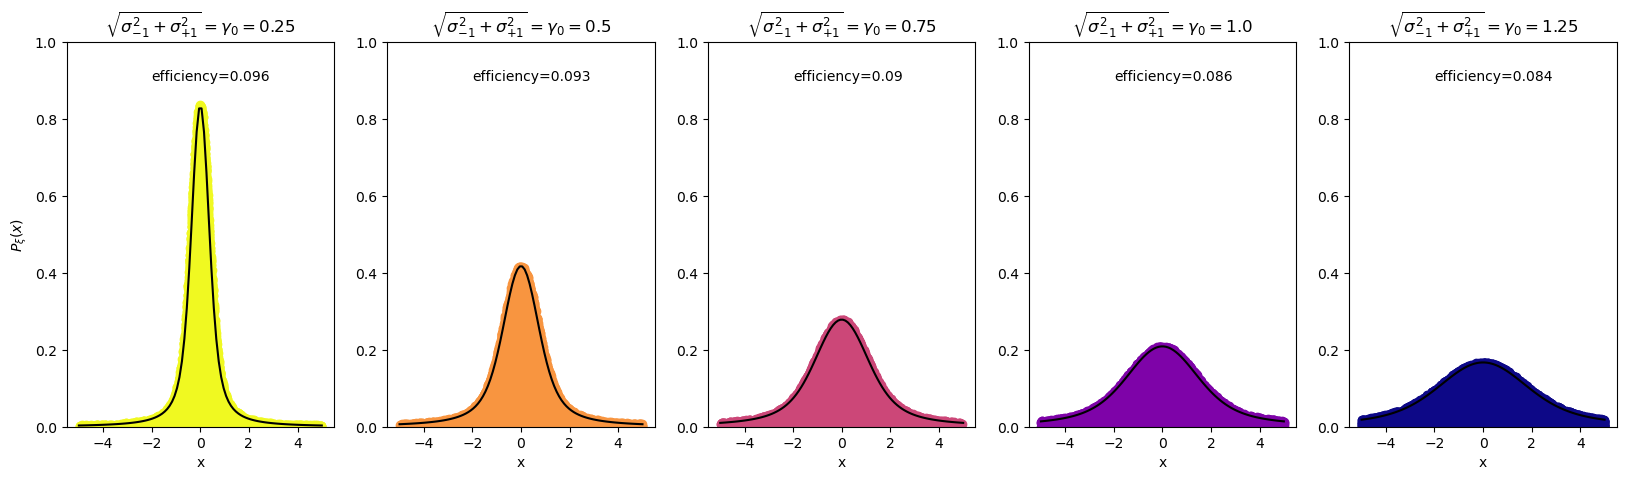

In [17]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

set_of_specs = np.arange(0.25, 1.5, 0.25)
colors = plt.cm.plasma(np.linspace(0, 1, len(set_of_specs))[::-1])

for i, spec in enumerate(set_of_specs):
    ax[i].set_title(r'$\sqrt{\sigma_{-1}^2  +  \sigma_{+1}^2}  = \gamma_0 = $' + f'{spec}')
    
    N_sampling = 10000
    points = sample_rejection(pde_voigt, N_sampling, params=(spec, spec))
    calls = points[:, 0].sum()

    ax[i].scatter(points[:,1], points[:,2], color=colors[i], label='rejection sampling')
    ax[i].text(-2, 0.9, f"efficiency={N_sampling/calls:.2}")
    ax[i].plot(np.linspace(-5, 5, 100), pde_voigt(np.linspace(-5, 5, 100), spec, spec), color='blacK')

    ax[i].set_xlabel('x')
    ax[i].set_ylim(0, 1)

ax[0].set_ylabel(r'$P_\xi(x)$')

Микровывод - увеличивая параметры и размзывая профиль ближе к 0, падаем в efficiency

##### 2.2 Второй метод founded on research - [*Lee, Jong-Sen. “Monte Carlo simulation of voigt distribution in Photon Diffusion Problems.” The Astrophysical Journal, vol. 187, Jan. 1974, p. 159*](https://adsabs.harvard.edu/full/1974ApJ...187..159L) и методе Бокса-Мюллера:

In [30]:
def voight_box_muller_sampling(bounds, params, call=0):
    """
    Input: (bounds, params, call=0):
    bounds - sampling box bounds, the only thing that limits performance, actually
    params - parameters of the Voight distribution 
    call   - rejection sampling iteration 

    Output -> (call, x1):
    call   - final number of rejection-sampling iterations
    x1     - accepted value 
    """

    call += 1

    r1 = np.random.uniform(0, 1)
    r2 = np.random.uniform(0, 1)
    r3 = np.random.uniform(0, 1)
  
    y1 = (-2*np.log(r1)) ** 0.5 * np.cos(2 * np.pi * r2) * (params[0])  
    v1 = params[1] * np.tan((r3 - 0.5) * np.pi) + y1

    if v1 <= bounds[1] and v1 >= bounds[0]:
        return call, v1
    else:
        return voight_box_muller_sampling(bounds, params, call=call)

def sample_vbml(n, bounds, params):
    return np.array([voight_box_muller_sampling(bounds, params) for i in range(n)])

Text(0, 0.5, '$P_\\xi(x)$')

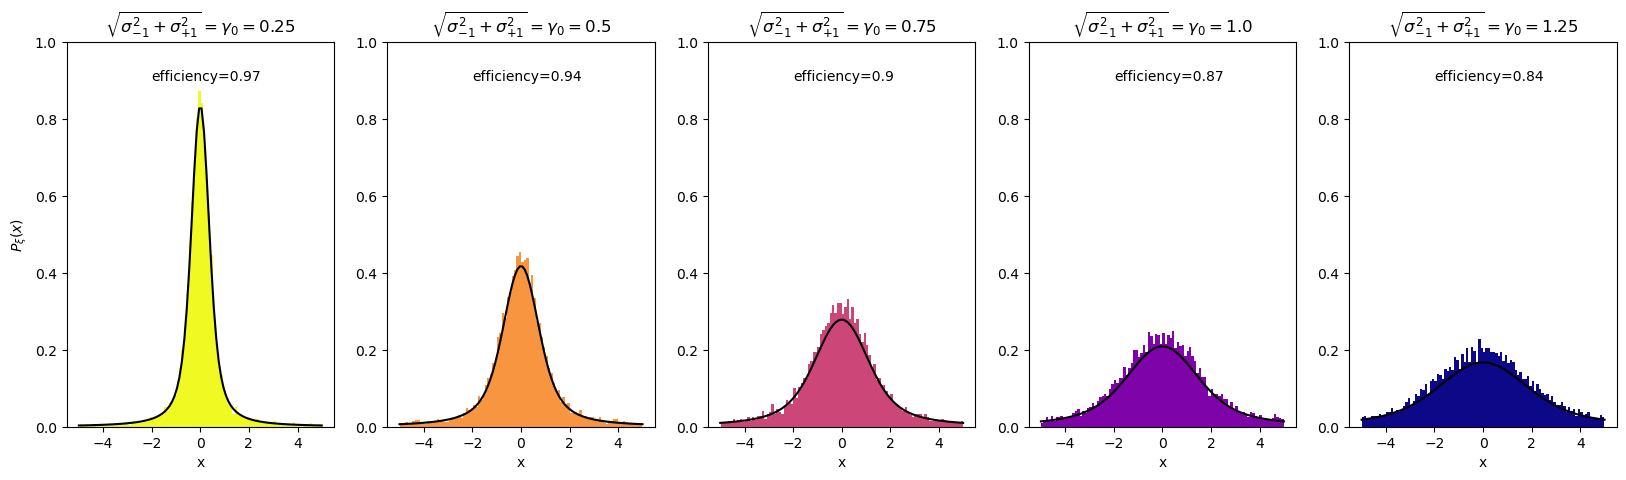

In [34]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

set_of_specs = np.arange(0.25, 1.5, 0.25)
colors = plt.cm.plasma(np.linspace(0, 1, len(set_of_specs))[::-1])

for i, spec in enumerate(set_of_specs):
    ax[i].set_title(r'$\sqrt{\sigma_{-1}^2  +  \sigma_{+1}^2}  = \gamma_0 = $' + f'{spec}')
    
    N_sampling = 10000
    points = sample_vbml(N_sampling, bounds=(-5, 5), params=(spec, spec))
    calls = points[:, 0].sum()
    
    ax[i].hist(points[:, 1], bins=100, density=True, color=colors[i], label='box-muller sampling')
    ax[i].text(-2, 0.9, f"efficiency={N_sampling/calls:.2}")
    ax[i].plot(np.linspace(-5, 5, 100), pde_voigt(np.linspace(-5, 5, 100), spec, spec), color='blacK')

    ax[i].set_xlabel('x')
    ax[i].set_ylim(0, 1)

ax[0].set_ylabel(r'$P_\xi(x)$')

Отметим, что перфоманс и "умного" сэмплера ухудшается при увелечение параметров, причем именно от роста $\gamma$, приводящего к увелечению "хвостов" распределения. Из-за этого больше точек отбрасывается при сэмплирование и растет среднее кол-во коллов $\Rightarrow$ качество падает.

### 3. (20 баллов) Рассмотрим функцию распределения вида:

$$ \rho(x, y) \propto \{ \frac{\gamma_x^{2n}}{(x - \mu_x)^{2n} + \gamma_x^{2n}} + \frac{\gamma_y^{2n}}{(x - \mu_y)^{2n} + \gamma_y^{2n}}  \}$$

##### 1. Запрограммируем ее имплементацию: 

In [158]:
def rho(x, y, mux, muy, gammax, gammay, n=1):
    x_sum = (x - mux) ** (2 * n) + gammax ** (2 * n)
    y_sum = (y - muy) ** (2 * n) + gammay ** (2 * n)
    
    return  gammax ** (2 * n) / x_sum + gammay ** (2 * n) / y_sum

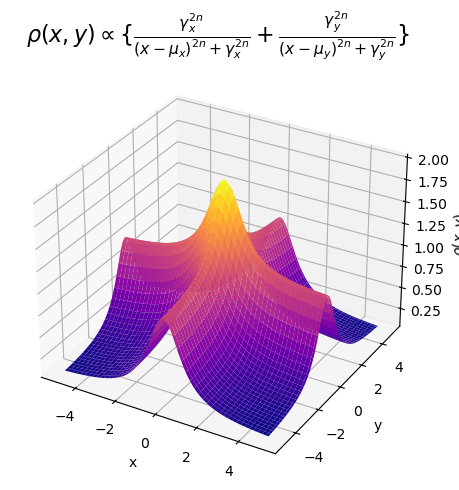

In [ ]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

X = np.linspace(-5, 5, 100)
Y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(X, Y)

Z1 = rho(X, Y, 0, 0, 1, 1)
ax.plot_surface(X, Y, Z1, cmap='plasma')
ax.set_title(r'$\rho(x, y) \propto \{\frac{\gamma_x^{2n}}{(x - \mu_x)^{2n} + \gamma_x^{2n}} + \frac{\gamma_y^{2n}}{(x - \mu_y)^{2n} + \gamma_y^{2n}}\}$', fontsize=16)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$\rho(x, y)$')

plt.tight_layout()
plt.show()

##### 2. Реализуем сэмплирование распределения методом Метрополиса-Гастингса

### 4. (20 баллов) 
##### *Реализуйте эффективный генератор столкновений фотонов с электронами, который бы позволил семплировать конечное состояние фотона после комптоновского рассеяния. Распределение конечных состояний подчиняется формуле Клейна-Нишины. В качестве параметров ваш семплер должен принимать энергию фотона и направление его прилёта, энергию электрона и направление его прилёта, а выдавать энергии фотона и электрона после рассеяния и направления их вылета.*